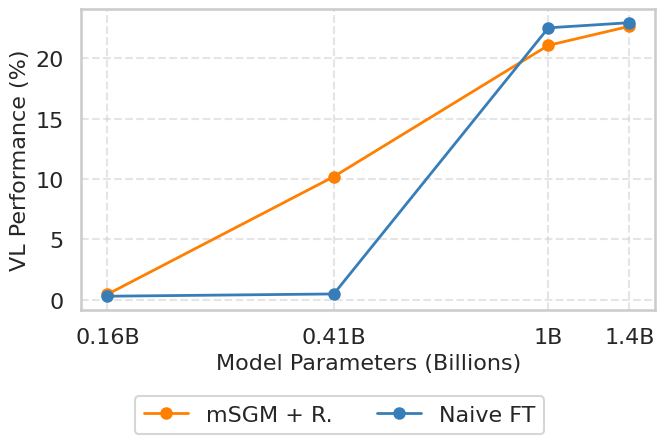

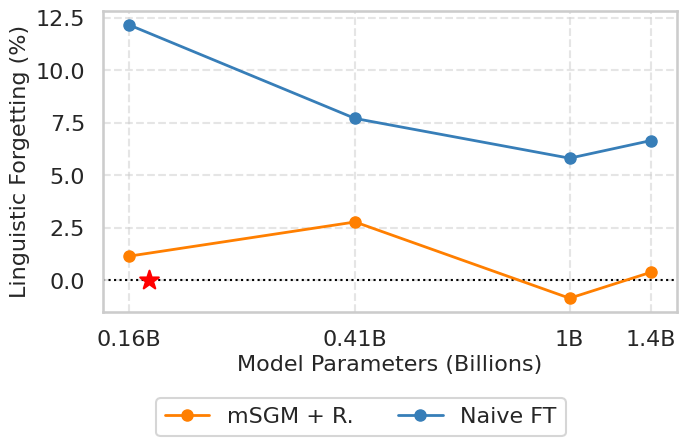

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import hmean

# Define a small epsilon value to replace zeros
EPSILON = 1e-3

# Define the dataset stages and the corresponding labels
stages = ["Task 2 (Instruct)", "Task 3 (VQA)", "Task 4 (OCR)", "Task 5 (Ref)"]
nlu_nlg_datasets = ["wsc273", "winogrande", "lambada_standard", "arc_easy", "arc_challenge"]
vl_datasets = ["vqa-v2", "textvqa-ocr", "textvqa-pure", "gqa", "refcoco"]
vl_evaluate_sequence = [["vqa-v2"], ["vqa-v2", "gqa"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure"], ["vqa-v2", "gqa", "textvqa-ocr", "textvqa-pure", "refcoco"]]

# Define explicit mappings for LLaVA, Our methods, and Base LLM
llava_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m", "cl-vqa-stage-1-pythia+160m", "cl-ocr-stage-2-pythia+160m", "cl-ref-stage-3-pythia+160m"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m", "cl-vqa-stage-1-pythia+410m", "cl-ocr-stage-2-pythia+410m", "cl-ref-stage-3-pythia+410m"],
    "1b": ["cl-instruct-stage-0-pythia+1b", "cl-vqa-stage-1-pythia+1b", "cl-ocr-stage-2-pythia+1b", "cl-ref-stage-3-pythia+1b"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b", "cl-vqa-stage-1-pythia+1p4b", "cl-ocr-stage-2-pythia+1p4b", "cl-ref-stage-3-pythia+1p4b"],
}

our_mapping = {
    "0.16b": ["cl-instruct-stage-0-pythia+160m-sgm", "cl-vqa-stage-1-pythia+160m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+160m-sgm-rehearsal1", "cl-ref-stage-3-pythia+160m-sgm-rehearsal1"],
    "0.41b": ["cl-instruct-stage-0-pythia+410m-sgm", "cl-vqa-stage-1-pythia+410m-sgm-rehearsal1", "cl-ocr-stage-2-pythia+410m-sgm-rehearsal1", "cl-ref-stage-3-pythia+410m-sgm-rehearsal1"],
    "1b": ["cl-instruct-stage-0-pythia+1b-sgm", "cl-vqa-stage-1-pythia+1b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1b-sgm-rehearsal1"],
    "1.4b": ["cl-instruct-stage-0-pythia+1p4b-sgm", "cl-vqa-stage-1-pythia+1p4b-sgm-rehearsal1", "cl-ocr-stage-2-pythia+1p4b-sgm-rehearsal1", "cl-ref-stage-3-pythia+1p4b-sgm-rehearsal1"],
}

base_llm_mapping = {
    "0.16b": "reproduction-align-pythia+160m",
    "0.41b": "reproduction-align-pythia+410m",
    "1b": "reproduction-align-pythia+1b",
    "1.4b": "reproduction-align-pythia+1p4b",
}

# Load the JSON data from the results file
with open('results_nlp.json', 'r') as file:
    results = json.load(file)

# Function to replace None values with a small positive value
def replace_none_and_zeros(arr, epsilon=EPSILON):
    return [epsilon if (x is None or np.isnan(x) or x == 0) else x for x in arr]

# Function to calculate performance changes and averages for each CL run
def calculate_performance(cl_runs, base_llm_mapping, results):
    performance = {}
    performance_change = {}

    for scale, run_ids in cl_runs.items():
        base_run_id = base_llm_mapping[scale]
        baseline_results = results.get(base_run_id)

        if not baseline_results:
            raise ValueError(f"Baseline run ID '{base_run_id}' not found in results.")

        changes = {}
        performances = {}
        for i, run_id in enumerate(run_ids):
            current_results = results.get(run_id)
            if not current_results:
                print(f"Run '{run_id}' missing for model '{scale}'")
                continue

            vl_evaluate_datasets = vl_evaluate_sequence[i]
            vl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            baseline_vl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in vl_evaluate_datasets])
            avg_acc_vl = hmean(vl_scores)
            avg_delta_vl = hmean(baseline_vl_scores) - avg_acc_vl

            nl_scores = replace_none_and_zeros([current_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            baseline_nl_scores = replace_none_and_zeros([baseline_results.get(dataset, np.nan) for dataset in nlu_nlg_datasets])
            avg_acc_nl = hmean(nl_scores)
            avg_delta_nl = hmean(baseline_nl_scores) - avg_acc_nl

            performances[f'stage_{i}_avg'] = {'VL': avg_acc_vl, 'NL': avg_acc_nl}
            changes[f'stage_{i}_avg'] = {'VL': avg_delta_vl, 'NL': avg_delta_nl}

        performance[scale] = performances
        performance_change[scale] = changes

    return performance, performance_change

# Calculate performance for our method and LLaVA method
our_performance, our_performance_change = calculate_performance(our_mapping, base_llm_mapping, results)
llava_performance, llava_performance_change = calculate_performance(llava_mapping, base_llm_mapping, results)

# Function to get performance for plotting after the last task (Task 5 (Ref))
def get_performance_after_last_task(performance, change, model_scales):
    vl_performance = []
    nl_forgetting = []
    for scale in model_scales:
        vl_performance.append(performance[scale]['stage_3_avg']['VL'] * 100)  # After Task 5 (Ref)
        nl_forgetting.append(change[scale]['stage_3_avg']['NL'] * 100)        # After Task 5 (Ref)
    return vl_performance, nl_forgetting

model_scales = ["0.16b", "0.41b", "1b", "1.4b"]

our_vl_performance, our_nl_forgetting = get_performance_after_last_task(our_performance, our_performance_change, model_scales)
llava_vl_performance, llava_nl_forgetting = get_performance_after_last_task(llava_performance, llava_performance_change, model_scales)

# Plotting the performance
sns.set(style="whitegrid")
sns.set_palette("muted")
sns.set_context("talk")
plt.rcParams.update({
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.figsize': [7, 5],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
    'lines.markersize': 8,
})

# Define colorblind-friendly palette
CB_palette = ['#377EB8', '#FF7F00', '#4DAF4A', '#F781BF']
# Plot VL Performance for Soft Targets and LLaVA
scale_to_label = {"0.16b": "0.16B", "0.41b": "0.41B", "1b": "1B", "1.4b": "1.4B"}

# Plot VL Performance
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_vl_performance, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_vl_performance, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('VL Performance (%)')

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('vl_performance_after_task_5.png', dpi=300)

# Plot Linguistic Forgetting
plt.figure()
plt.xscale('log')
line1, = plt.plot([0.16, 0.41, 1.0, 1.4], our_nl_forgetting, color=CB_palette[1], marker='o', linestyle='-')
line2, = plt.plot([0.16, 0.41, 1.0, 1.4], llava_nl_forgetting, color=CB_palette[0], marker='o', linestyle='-')

plt.xticks([0.16, 0.41, 1.0, 1.4], ['0.16B', '0.41B', '1B', '1.4B'])
plt.xlabel('Model Parameters (Billions)')
plt.ylabel('Linguistic Forgetting (%)')

# Highlight the 0 horizontal line
plt.axhline(0, color='black', linestyle=':', linewidth=1.5, zorder=1)
plt.scatter(0.174, 0, color='red', marker='*', s=200, zorder=5)

plt.legend(handles=[line1, line2], labels=['mSGM + R.', 'Naive FT'], loc='upper center', bbox_to_anchor=(0.45, -0.25), ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig('nl_forgetting_after_task_5.png', dpi=300)

plt.show()
